<a href="https://colab.research.google.com/github/harshitadd/FedBased_X-RayForCoVID/blob/master/FederatedCoVIDdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Importing Mini Batch Data 
import os 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install pydicom 
import pydicom 
import cv2
import matplotlib.pyplot as plt 

     |████████████████████████████████| 35.3MB 117kB/s 


In [0]:
dcm_path=os.listdir('/content/drive/My Drive/Fed_Covid/minibatch/')
dcm_data={}

alpha = 1.5 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)

ctr=0
for file in dcm_path:
  name = '/content/drive/My Drive/Fed_Covid/minibatch/' + file
  temp = pydicom.dcmread(name)
  image = temp.pixel_array
  ## Enhanced contrast and added colour
  adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
  dcm_data[file]=adjusted
  ctr+=1
  print(ctr)

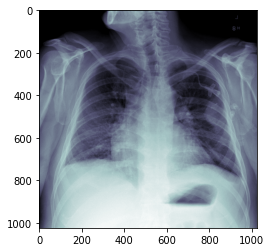

In [25]:
# plt.imshow(image,cmap=plt.cm.bone)

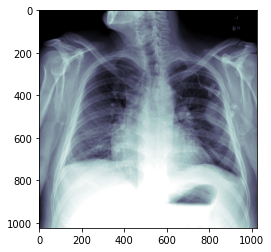

In [32]:
# # plt.imshow(adjusted,cmap=plt.cm.bone)
# alpha=1.2
# beta=1
# adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
# plt.imshow(adjusted,cmap=plt.cm.bone)


In [10]:
print(len(dcm_data))

427


In [0]:
# import pickle
# with open('/content/features_dcm.bin','wb') as file:
#   pickle.dump(dcm_data,file)

In [0]:
import csv 
labels=[]
with open('/content/stage_2_train_labels.csv','r') as file:
  reader = csv.reader(file)
  for row in reader:
    labels.append(row)

In [61]:
print(len(labels))
print(len(dcm_data))

30228
427


In [0]:
pid=[]
dicom=[]
label=[]
for PID in labels:
  for key in dcm_data:
    if(key[:-4]==PID[0]):
      pid.append(key)
      dicom.append(dcm_data[key])
      label.append(PID[5])
      

In [0]:
##CHECKING 
# print(final_data[45])

In [63]:
print(len(dicom))
print(len(label))

429
429


In [0]:
## Making Training DF 
import pandas as pd
final_data = pd.DataFrame()
final_data['PatientID']=pid 
final_data['dicom']=dicom
final_data['label']=label

In [16]:
final_data

,PatientID,dicom,label
0,fcac5979-fa02-40ad-bd07-70da89e391fb.dcm,"[[3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,...",0
1,fcad0e40-e0d7-4f32-b914-e19041bfd149.dcm,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0
2,fcad22d2-efe3-4fdc-87a6-7710d37e9111.dcm,"[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,...",0
3,fcad64f6-177e-4042-8cd1-0c10e234c82e.dcm,"[[3, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,fcae3037-2029-4c72-9204-cb11b4113e1a.dcm,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
...,...,...,...
424,fffb2395-8edd-4954-8a89-ffe2fd329be3.dcm,"[[3, 4, 4, 4, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3,...",1
425,fffba05a-1635-4545-9bbd-57ad4cfe8d27.dcm,"[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,...",0
426,fffc95b5-605b-4226-80ab-62caec682b22.dcm,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 10, 44, ...",0
427,fffcff11-d018-4414-971a-a7cefa327795.dcm,"[[104, 96, 93, 86, 69, 52, 38, 27, 14, 10, 8, ...",0


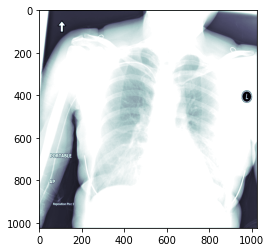

In [27]:
plt.imshow(dicom[78], cmap=plt.cm.bone)

In [0]:
import numpy as np

In [0]:
dicom = np.array(dicom)
label = np.array(label,dtype=np.int16)

In [68]:
print(len(dicom))
print(len(label))

429
429


In [0]:
##Preparing train/test data 
x_train,x_test,y_train,y_test=train_test_split(dicom,label,test_size=0.3)

In [74]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))


(300, 1024, 1024)
(300,)
(129, 1024, 1024)
(129,)


In [0]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Conv1D,Flatten

In [83]:
tf.__version__

'2.2.0-rc1'

In [0]:
model = Sequential()

In [108]:
print(np.shape(x_train))

(300, 1024, 1024)


In [0]:
#Conv Net for training 

model.add(Conv1D(64, kernel_size=6, activation='relu', input_shape=(1024,1024)))
model.add(Conv1D(32, kernel_size=6, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))


In [0]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [126]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1019, 64)          393280    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1014, 32)          12320     
_________________________________________________________________
flatten_7 (Flatten)          (None, 32448)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 64898     
Total params: 470,498
Trainable params: 470,498
Non-trainable params: 0
_________________________________________________________________


In [127]:
hist = model.fit(x_train, y_train, validation_split = 0.33, epochs = 10,verbose = 1, batch_size = 32, shuffle = True)

Epoch 1/10
7/7 [==============================] - 12s 2s/step - loss: 7.6377 - accuracy: 0.7950 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 2/10
7/7 [==============================] - 12s 2s/step - loss: 7.6427 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 3/10
7/7 [==============================] - 12s 2s/step - loss: 7.6427 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 4/10
7/7 [==============================] - 12s 2s/step - loss: 7.6415 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 5/10
7/7 [==============================] - 12s 2s/step - loss: 7.6427 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 6/10
7/7 [==============================] - 12s 2s/step - loss: 7.6415 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 7/10
7/7 [==============================] - 12s 2s/step - loss: 7.6403 - accuracy: 0.8000 - val_loss: 7.6363 - val_accuracy: 0.8300
Epoch 8/10
7/7 [==================

In [128]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.791
